# Project 1: Randomized Experiments 👶

<!-- ---
myst:
  html_meta:
    "description": "Project 1: Randomized Experiment"
title: "[SOLUTION] Project 1: Randomized Experiment"
exports:
  - format: pdf
kernelspec:
  display_name: Python 3
  name: python3
--- -->

In this project, we will conduct our first causal study by examining the Infant Health and Development Program (IHDP) dataset, which is a classic dataset in the causal inference literature.

## Learning Objectives

- Practice taking a research question, matching it to a causal estimand, and analyzing data to estimate the causal effect.
- Explore the benefits of stratification in a randomized experiment.
- Practice translating mathematical quantities into code by implementing two difference-in-means estimators and computing confidence intervals.
- Exercise your data manipulation and visualization skills with real and simulated data.

```{note}
This project is due at **xyz at 10:00pm.**
```

## Table of Contents and Rubric

| Section | Points |
|------------------------------------|-------|
| [Math to code: difference-in-means implementation](#1-difference-in-means) | 2 |
| [Interactivity: stratified vs unstratified estimators](#2-exploring-the-efficiency-of-difference-in-means-estimators) | 2 |
| Causal study design: IHDP | 2 |
| Math to code: bootstrapped variances and confidence intervals | 1 |
| Causal estimation and interpretation: IHDP analysis | 2 |
| Reflection | 1 |
| Total | 10 pts

## How to submit

Like our worksheets, you will upload **two** files to Gradescope:
- a proj1_random_experiment.py file, which can be downloaded by going into the Jupyterlab menu: "File -> Save and Export Notebook As -> Executable Script"
- a fully rendered proj1_random_experiment.pdf file

```{warning} TODO
Figure out pdf rendering with myst stack
```

## Notebook imports

```{tip}
Don't forget to run this cell to import all of the relvant python modules!
```

In [1]:
# run me!
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

## 1. Difference-in-means

We begin by considering the causal graph for a randomized experiment, where there are the following variables:

- $T$: the intervention, or **T**reatment of interest
- $Y$: the outcome of interest
- $X$: a covariate that affects the outcome of interest
- $U$: any unobserved confounders

```{note}
Remember that randomizing a variable removes all incoming edge connections in the graph!
```

![](../images/proj1_dag.svg)

We provide the following code for simulating a random experiment with a binary treatment $T$ and binary covariate $X$:

In [2]:
rng = np.random.default_rng(seed=42)

def sim_random_exp(n_samples=1000, treatment_effect=1.0, covariate_effect=3.0):
    """
    Simulate a random experiment with a binary treatment and covariate.

    Args:
        n_samples (int): the number of samples to simulate
        treatment_effect (float): the magnitude of the effect of the treatment on the outcome
        covariate_effect (float): the magnitude of the effect of the covariate on the outcome

    Returns:
        Y (np.ndarray): the observed outcome
        T (np.ndarray): the binary  treatment assignment
        X (np.ndarray): the binary covariate
    """
    # Generate potential outcomes
    Y0 = rng.normal(size=n_samples)
    Y1 = Y0 + treatment_effect

    # Randomly assign treatment
    T = rng.choice([0, 1], size=n_samples, )

    # Create a binary covariate that affects the outcome
    X = rng.choice([0, 1], size=n_samples)

    # Generate the observed outcome
    Y = np.where(T == 1, Y1, Y0) + covariate_effect*X

    return Y, T, X

Under this randomization, we are able to **identify** the causal estimand we have been discussing, the average treatment effect ($\tau$):

$$
\tau = E[Y(1) - Y(0)] \; \xrightarrow[]{\text{Identification}} \; E[Y | T = 1] - E[Y | T = 0]
$$

We can then estimate the causal effect by taking the difference in means between the treated and control groups:

$$
\hat{\tau}= \frac{1}{n_1} \sum_{i=1}^{n_1} Y_i - \frac{1}{n_0} \sum_{i=1}^{n_0} Y_i
$$

where $n_1$ is the number of samples in the treatment group, and $n_0$ is the number of samples in the control group.

### 1.1. Implement `diff_in_means` [1 pt]

In [3]:
def diff_in_means(Y, T):
    """
    Computes the difference in means between the treatment and control groups.

    Args:
        Y (np.ndarray): the observed outcome
        T (np.ndarray): the binary treatment assignment

    Returns:
        float: the difference in means estimate
    """
    assert Y.shape == T.shape, "Y and T must have the same shape"
    
    ### BEGIN SOLUTION
    return Y[T == 1].mean() - Y[T == 0].mean()
    ### END SOLUTION

test_Y = np.array([2, 1, 2, 1])
test_T = np.array([1, 0, 1, 0])

assert np.isclose(diff_in_means(test_Y, test_T), 1)
# Feel free to add more tests

### 1.2. Implement `stratified_diff_in_means` [1 pt]

We saw in lecture that if we want to include a covariate in our analysis, we can analogously compute the difference in means between the treated and control groups, but now conditioning on the covariate. We implement this here as a **stratified difference-in-means** estimator, which is defined as the difference in means between the treatment and control groups, stratified by the binary covariate $X$.

$$
\hat{\tau}_\text{stratified} = \sum^K_{k=1} \frac{n_k}{n} \hat{\tau}_k
$$

where $K$ are the total number of strata, $n_k$ is the number of samples in stratum $k$, and $\hat{\tau}_k$ is the difference-in-means estimator for stratum $k$:

$$
\hat{\tau}_k = \frac{1}{n_{k1}} \sum_{i=1}^{n_{k1}} Y_i - \frac{1}{n_{k0}} \sum_{i=1}^{n_{k0}} Y_i
$$

where $n_{k1}$ is the number of samples in the treatment group for stratum $k$, and $n_{k0}$ is the number of samples in the control group for stratum $k$.

```{tip} Hint

While these equations may look a bit complicated, notice that each individual summation term in $\hat{\tau}_k$ is just a mean of the outcome for a given subset of the data. In particular, in our case where $X$ is binary:

- $\frac{1}{n_{11}} \sum_{i=1}^{n_{11}} Y_i$ is the mean of the outcome when $X=1$ and $T=1$
- $\frac{1}{n_{10}} \sum_{i=1}^{n_{10}} Y_i$ is the mean of the outcome when $X=1$ and $T=0$
- and analogously for $X=0$

You can then use numpy's boolean indexing to compute the means for each stratum.
```

In [4]:
def diff_in_means_stratified(Y, T, X):
    """
    Compute the difference in means stratified by binary covariate X.
    """
    
    ### BEGIN SOLUTION
    X1_effect = Y[(T == 1) & (X == 1)].mean() - Y[(T == 0) & (X == 1)].mean()
    X0_effect = Y[(T == 1) & (X == 0)].mean() - Y[(T == 0) & (X == 0)].mean()

    # NOTE: stratified difference in means may be undefined if strata are empty
    return X1_effect*X.mean() + X0_effect*(1-X.mean())
    ### END SOLUTION

test_Y = np.array([2, 1, 2, 1])
test_T = np.array([1, 0, 1, 0])
test_X = np.array([1, 1, 0, 0])

assert np.isclose(diff_in_means_stratified(test_Y, test_T, test_X), 1)
# Feel free to add more tests

## 2. Exploring the efficiency of difference-in-means estimators

### 2.1 Interactive widget [1 pt]

We provide the `gen_experiment_results` function to simulate `n_experiments` random experiments and compute the difference-in-means and stratified difference-in-means estimators.

```{warning} TODO
Should we ask the students to implement this?
```

In [5]:
def gen_experiment_results(n_experiments=10000, **kwargs):
    """
    Simulates `n_experiments` random experiments and computes the difference-in-means and stratified difference-in-means estimators.

    Args:
        n_experiments (int): the number of experiments to simulate
        **kwargs: additional keyword arguments to pass to `sim_random_exp`

    Returns:
        pd.DataFrame: a dataframe with the results of the experiments
    """
    experiment_results = {
        "diff_in_means": [],
        "diff_in_means_stratified": []
    }

    ### BEGIN SOLUTION
    for i in range(n_experiments):
        Y, T, X = sim_random_exp(**kwargs)

        experiment_results["diff_in_means"].append(diff_in_means(Y, T))
        experiment_results["diff_in_means_stratified"].append(diff_in_means_stratified(Y, T, X))
    ### END SOLUTION
    
    # Converts dictionary to dataframe with keys as column names
    exp_df = pd.DataFrame(experiment_results)

    return exp_df

Using the `gen_experiment_results` function, create a **manual** interactive widget that plots the difference-in-means for a range of covariate effects. Specifically, you should:

- Add a `interact_manual` decorator to the `plot_ihdp_data` function
- Create a slider for the covariate effect that can take values between 0 and 6
- **Fix** the number of experiments to 10000
- Call the `gen_experiment_results` function with the given number of experiments and covariate effect
- Plot a histogram of the difference-in-means, unstratified and stratified for a given covariate effect: this should be a single plot with two histograms on top of each other, which can be achieved using `sns.histplot`
- Additionally, plot the true difference in means as a vertical line on the same figure, which can be achieved using `plt.axvline`. The default treatment effect is `1.0`


```{note}
Remember to follow good figure design practices!
```


In [6]:
@widgets.interact_manual(num_experiments=widgets.fixed(10000), covariate_effect=widgets.FloatSlider(min=0, max=6, step=1, value=3.0))
def plot_ihdp_data(num_experiments=10000, covariate_effect=3.0):
    exp_df = gen_experiment_results(n_experiments=num_experiments, covariate_effect=covariate_effect)

    sns.histplot(exp_df)

    plt.xlabel("Difference in means")
    plt.ylabel("Frequency")
    plt.axvline(x=1, color='black', linestyle='--', label="True difference in means")
    plt.title("Distribution of difference-in-means")
    plt.show()

interactive(children=(FloatSlider(value=3.0, description='covariate_effect', max=6.0, step=1.0), Button(descri…

### 2.2 Interpretation [1 pt]

Recall our discussions of the **bias** and **variance** of treatment effect estimators:

- **Bias**: how far off is the mean estimate off from the true value? We can visually inspect this by looking at where the histogram is "centered."
- **Variance**: how much do the estimates for a given experiment vary? We can visually inspect this by looking at how "spread out" the histogram is.

Play around with the widget you created above, testing out different covariate effect values.

1. What do you observe about the bias of the unstratified and stratified estimators? Is either biased?

2. What do you observe about the variance of the unstratified and stratified estimators? We typically call estimators with lower variance to be **more efficient**. Is there an estimator that appears to be more efficient?


3. What happens to the relative efficiency of the two estimators when you set the covariate effect to 0? Why do you think this occurs?


**TODO** your responses here

1. 

2. 

3. 

## 3. Causal study design: IHDP

Let's now dive into analyzing a real-world study: the Infant Health and Development Program (IHDP). The IHDP was a randomized experiment conducted in the 1980s to evaluate the effectiveness of an early intervention program for low-birthweight, prematurely born infants.

### 3.1 Exploring the IHDP dataset [1 pt]

Read the following resources on the IHDP study:

- [IHDP policy memo](https://policyforchildren.org/wp-content/uploads/2013/08/IHDP-Final-5.11.10.pdf)
- [Brooks-Gunn et al. 1991](https://www.jpeds.com/article/S0022-3476(05)80896-0/pdf)], pages 350-352


```{tip}
The Brooks Gunn et al. 1991 paper contains minute details about the study recruitment and data collection process. Don't worry about understanding every aspect of the study, but try to get a sense of the overall experimental design and the baseline characteristics reported in Table 1.
```

Answer the following questions:

1. State what the fundamental problem of causal inference is in the context of the treatment and control groups in this study.

2. The outcome of interest we will be analyzing is the **Stanford-Binet Intelligence Scale score** (IQ) at an age of 36 months (3 years), and our **causal estimand** is the **average treatment effect** on the child's IQ score. State what causal question we are trying to answer in this dataset.


**TODO** your responses here:

1. 

2. 



Next, let's load the IHDP dataset and explore the data:

In [7]:
ihdp_raw = pd.read_csv('../data/ihdp_real.csv')
ihdp_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     985 non-null    int64  
 1   iqsb.36        908 non-null    float64
 2   dose400        985 non-null    int64  
 3   treat          985 non-null    int64  
 4   bw             985 non-null    int64  
 5   momage         985 non-null    int64  
 6   nnhealth       985 non-null    int64  
 7   birth.o        985 non-null    int64  
 8   parity         985 non-null    int64  
 9   moreprem       985 non-null    int64  
 10  cigs           985 non-null    int64  
 11  alcohol        985 non-null    int64  
 12  ppvt.imp       985 non-null    float64
 13  bwg            985 non-null    int64  
 14  female         985 non-null    int64  
 15  mlt.birt       985 non-null    int64  
 16  b.marry        985 non-null    int64  
 17  livwho         985 non-null    int64  
 18  language  



There are 50 total columns in the dataframe, but we will only use the following columns:

- `bw`: birth weight in grams
- `momage`: mother's age in years
- `iqsb.36`: IQ score at 36 months
- `treat`: binary treatment assignment

Let's ensure that the baseline characteristics are balanced between the treatment and control groups. Complete the `baseline_stats` function below to verify that the `bw` and `momage` characteristics are balanced and roughly match the values reported in Table 1 of Brooks-Gunn et al.

```{tip}
This operation can be done in one line by using pandas `groupby()`, followed by the `agg()` operation to compute the mean and standard deviation.
```

In [8]:
def baseline_stats(df, covariate):
    """
    Computes the mean and standard deviation of a covariate 
    for the treatment and control groups.
    Assumes that the treatment indicator column is named `treat`.

    Args:
        df (pd.DataFrame): the dataframe to compute the baseline stats
        covariate (str): the name of the covariate to compute the baseline stats

    Returns:
        pd.DataFrame: a grouped dataframe with the mean and standard deviation 
            of the covariate for the treatment and control groups
    """
    ### BEGIN SOLUTION    
    grouped = df.groupby('treat').agg({covariate: ['mean', 'std']})
    return grouped
    ### END SOLUTION

display(baseline_stats(ihdp_raw, 'bw'))
display(baseline_stats(ihdp_raw, 'momage'))


bw            
              mean         std
treat                         
0      1781.322368  468.036980
1      1819.323607  438.809313

momage          
            mean       std
treat                     
0      24.886513  6.097663
1      24.586207  5.932118

### 3.2 Visualizing and cleaning the data [1 pt]

Beyond having similar mean and standard deviation, an implication of exchangeability is that the treatment and control groups should have a similar *distribution* of covariates. We can inspect this by plotting the (cumulative) distribution of the covariates for the treatment and control groups and visually inspecting whether the two distributions are similar.

Let's verify this is the case for both `bw` and `momage`, using a distribution plot via `sns.kdeplot`. Specfically, complete the `plot_covariate_distribution` function below by generating a kde plot with:

- the covariate on the x-axis
- `treat` as the hue
- `ihdp_df` as the data
- `common_norm=False` to ensure that the y-axis is on the same scale for both the treatment and control groups
- `cumulative=True` to plot the cumulative distribution

```{note}
For the statistically curious: a natural hypothesis to test here is whether the two distributions are statistically different, which can be done using a two-sample Kolmogorov-Smirnov test.
```

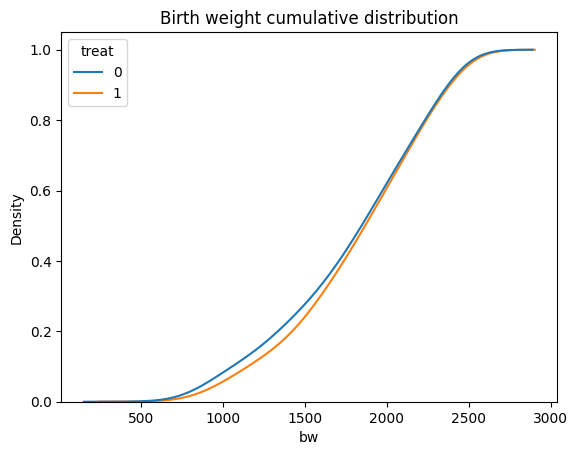

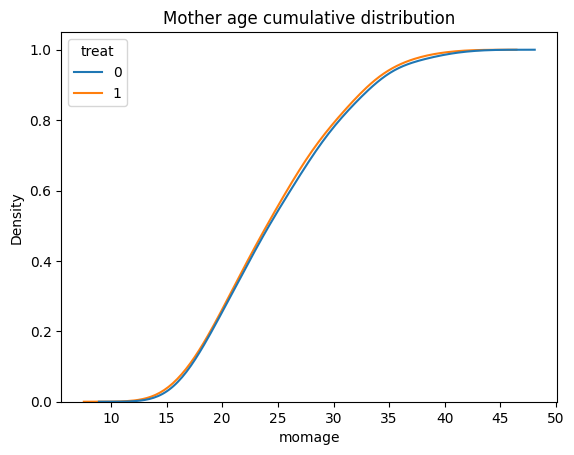

In [9]:
def plot_covariate_distribution(df, covariate, title):
    """
    Plots the distribution of a covariate for the treatment and control groups.

    Args:
        df (pd.DataFrame): the dataframe to plot the covariate distribution
        covariate (str): the name of the covariate to plot
        title (str): the title of the plot
    
    Returns:
        None, but shows the covariate distribution plot
    """
    ### BEGIN SOLUTION
    sns.kdeplot(x=covariate, hue='treat', cumulative=True, common_norm=False, data=df)
    plt.title(title)
    ### END SOLUTION
    plt.show()

plot_covariate_distribution(ihdp_raw, 'bw', 'Birth weight cumulative distribution')
plot_covariate_distribution(ihdp_raw, 'momage', 'Mother age cumulative distribution')

Our outcome is `iqsb.36`, which are the infant's IQ score at 36 months. However, there are some missing values in the `iqsb.36` column, so we need to drop the rows that do not have the outcome.

Complete the `load_and_clean_ihdp_data` function below, and then run the cell to load the cleaned dataset.

In [10]:
def load_and_clean_ihdp_data():
    """
    Loads the IHDP dataset and drops the rows that do not have the outcome.

    Returns:
        pd.DataFrame: the cleaned IHDP dataset
    """

    ihdp_df = pd.read_csv('../data/ihdp_real.csv')

    ### BEGIN SOLUTION

    # TODO Drop rows that do not have the outcome
    ihdp_df = ihdp_df[ihdp_df['iqsb.36'].notna()]
    ### END SOLUTION

    assert ihdp_df.shape[0] == ihdp_df['iqsb.36'].notna().sum()
    return ihdp_df

ihdp_clean = load_and_clean_ihdp_data()

## 4. Bootstrapped confidence intervals

### 4.1 Bootstrap utility functions [1 pt]

Since we only have one real dataset, we cannot generate a distribution of the difference-in-means estimator over multiple experiments. However, we can use bootstrapping to generate a distribution of the difference-in-means estimator. 

As we saw in worksheet **TODO**, bootstrapping is a powerful technique that allows us to generate a distribution over *any* estimator by resampling the data with replacement. Complete the `bootstrap_dfs` function below, which takes in a dataframe and returns a list of bootstrapped dataframes.


```{warning} TODO
This moves fast through bootstrapping, will need worksheet 3 to go through it in more detail
```

```{tip} Hint

You can use the `pd.DataFrame.sample` method to sample rows with replacement. Check out the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) for more details.
```

In [11]:
def bootstrap_dfs(df, n_bootstraps=10000):
    """
    Bootstraps the dataframe `n_bootstraps` times.

    Args:
        df (pd.DataFrame): the dataframe to bootstrap
        n_bootstraps (int): the number of bootstraps to generate

    Returns:
        list[pd.DataFrame]: a list of bootstrapped dataframes
    """
    bootstrap_dfs = []

    ### BEGIN SOLUTION
    for i in range(n_bootstraps):
        bootstrap_dfs.append(df.sample(frac=1, replace=True))
    ### END SOLUTION

    return bootstrap_dfs

assert len(bootstrap_dfs(ihdp_clean)) == 10000

Once we have our bootstrapped dataframes, we can apply an estimator to each bootstrap, which will give us a distribution of the estimator. We can then use this distribution to compute a variance and confidence interval for the estimator. 

Given our difference-in-means estimator $\hat{\tau}$, we can compute the variance of the estimator as the sample variance of the bootstrapped estimates.

$$
\hat{V}[\hat{\tau}] = \frac{1}{B-1} \sum_{i=1}^{B} (\hat{\tau}_i - \bar{\tau})^2
$$

Where $B$ is the number of bootstraps, $\hat{\tau}_i$ is the estimate for the $i$-th bootstrap, and $\bar{\tau}$ is the mean of the bootstrapped estimates:

$$
\bar{\tau} = \frac{1}{B} \sum_{i=1}^{B} \hat{\tau}_i
$$

Conveniently, numpy has a built-in function to compute the standard deviation (the square root of the variance), which we can use here: `np.std`.

This then allows us to compute a confidence interval for the difference-in-means estimator.

$$
\text{CI}_{\text{lower}}(\hat{\tau}) = \hat{\tau} - z_{\alpha/2} \cdot \sqrt{\hat{V}(\hat{\tau})}
$$

$$
\text{CI}_{\text{upper}}(\hat{\tau}) = \hat{\tau} + z_{\alpha/2} \cdot \sqrt{\hat{V}(\hat{\tau})}
$$

$$
\text{CI}(\hat{\tau}) = [\text{CI}_{\text{lower}}(\hat{\tau}), \; \text{CI}_{\text{upper}}(\hat{\tau})]
$$

where $z_{\alpha/2}$ is the $1-\alpha/2$ quantile of the standard normal distribution. This can be computed using `norm.ppf` from the `scipy.stats` library:

```python
from scipy.stats import norm

z_alpha_2 = norm.ppf(1 - alpha / 2)
```

Complete the `bootstrap_ci` function below, which takes in a list of bootstrap values and returns a confidence interval for the estimator.

In [12]:
from scipy.stats import norm

def bootstrap_ci(bootstrap_values, alpha=0.05):
    """
    Computes the confidence interval for the estimator using bootstrapping.

    Args:
        bootstrap_values (list[float]): the bootstrapped values
        alpha (float): the significance level

    Returns:
        list[float]: the confidence interval [lower, upper]
    """
    ### BEGIN SOLUTION
    std = np.std(bootstrap_values)
    mean = np.mean(bootstrap_values)

    z_alpha_2 = norm.ppf(1 - alpha / 2)

    return [mean - z_alpha_2 * std, mean + z_alpha_2 * std]
    ### END SOLUTION

## 5. Causal estimation and interpretation: IHDP analysis

### 5.1 Difference-in-means results [1 pt]

We'll now want to apply our difference-in-means estimators to the IHDP dataset. In order to use our stratified difference-in-means estimator, we need to binarize the `bw` and `momage` covariates. Complete the following `binarize_covariate` function, which creates a new binary covariate that is 1 if the covariate is greater than the cutpoint, and 0 otherwise.

Then, apply the `binarize_covariate` function to the `momage` and `bw` covariates:
- using a cutpoint of 22 years for `momage`
- using a cutpoint of 2000 grams for `bw`

In [13]:
def binarize_covariate(df, covariate, cutpoint):
    """
    Creates a new binary covariate that is 1 if the covariate is greater than the cutpoint, and 0 otherwise.
    Updates the dataframe in place with a new column named `{covariate}_bin`

    Args:
        df (pd.DataFrame): the dataframe to update
        covariate (str): the name of the covariate to binarize
        cutpoint (float): the cutpoint to use for binarization

    Returns:
        pd.DataFrame: the updated dataframe with the new binary covariate
    """
    ### BEGIN SOLUTION
    df[f"{covariate}_bin"] = (df[covariate] > cutpoint).astype(int)
    ### END SOLUTION
    
    return df

df = pd.DataFrame({'A': [1, 2, 3, 4, 5]})
assert binarize_covariate(df, 'A', 2.5).equals(pd.DataFrame({'A': [1, 2, 3, 4, 5], 'A_bin': [0, 0, 1, 1, 1]}))

# TODO call binarize_covariate on the `momage` and `bw` covariates
ihdp_clean = binarize_covariate(ihdp_clean, 'momage', 22)
ihdp_clean = binarize_covariate(ihdp_clean, 'bw', 2000)

Finally, let's compute our results. For the following difference-in-means estimators:
 - unstratified difference-in-means estimator for the `iqsb.36` outcome
 - stratified difference-in-means estimator for the `iqsb.36` outcome, binarized by `momage`
 - stratified difference-in-means estimator for the `iqsb.36` outcome, binarized by `bw`

Compute and report the following in the markdown table below (up to two decimal places):
- the estimate for the difference-in-means estimator, **using the original dataset**.
- the bootstrapped 95% confidence interval for the difference-in-means estimator
- the length of the confidence interval, which is the difference between the upper and lower bounds of the confidence interval

```{tip}
See the comments in the code cell below for guidance on how to organize your analysis.
```

In [14]:

### BEGIN SOLUTION

# TODO get point estimates
point_estimates = {
    "unstratified": diff_in_means(ihdp_clean['iqsb.36'], ihdp_clean['treat']),
    "stratified_momage": diff_in_means_stratified(ihdp_clean['iqsb.36'], ihdp_clean['treat'], ihdp_clean['momage_bin']),
    "stratified_bw": diff_in_means_stratified(ihdp_clean['iqsb.36'], ihdp_clean['treat'], ihdp_clean['bw_bin'])
}

# TODO generate bootstraps
bs_dfs = bootstrap_dfs(ihdp_clean)

# TODO store difference-in-means results in a dict
bootstrap_results = {
    "unstratified": [],
    "stratified_momage": [],
    "stratified_bw": []
}

# TODO compute difference-in-means for each bootstrapped dataframe
for df in bs_dfs:
    bootstrap_results["unstratified"].append(diff_in_means(df['iqsb.36'], df['treat']))
    bootstrap_results["stratified_momage"].append(diff_in_means_stratified(df['iqsb.36'], df['treat'], df['momage_bin']))
    bootstrap_results["stratified_bw"].append(diff_in_means_stratified(df['iqsb.36'], df['treat'], df['bw_bin']))

# TODO report the results for each estimator
for estimator, results in bootstrap_results.items():
    print(f"{estimator}:")
    # TODO more print statements
    print(f"  Point estimate: {point_estimates[estimator]}")
    print(f"  Confidence interval: {bootstrap_ci(results)}")
    print(f"  Confidence interval length: {bootstrap_ci(results)[1] - bootstrap_ci(results)[0]}")

### END SOLUTION

unstratified:
  Point estimate: 8.977258600584591
  Confidence interval: [np.float64(6.34886030577672), np.float64(11.59812864648534)]
  Confidence interval length: 5.249268340708621
stratified_momage:
  Point estimate: 9.214304026296691
  Confidence interval: [np.float64(6.665450491414793), np.float64(11.754512350387115)]
  Confidence interval length: 5.089061858972322
stratified_bw:
  Point estimate: 8.984536879224663
  Confidence interval: [np.float64(6.377465161309322), np.float64(11.588504548601987)]
  Confidence interval length: 5.211039387292665


| Estimator | Effect | 95% CI | Length of CI |
| --- | --- | --- | --- |
| Difference-in-means | TODO | TODO | TODO |
| Difference-in-means stratified by `bw_bin` | TODO | TODO | TODO |
| Difference-in-means stratified by `momage_bin` | TODO | TODO | TODO |

<!--BEGIN SOLUTION-->
| Estimator | Effect | 95% CI | Length of CI |
| --- | --- | --- | --- |
| Difference-in-means | TODO | TODO | TODO |
| Difference-in-means stratified by `bw_bin` | TODO | TODO | TODO |
| Difference-in-means stratified by `momage_bin` | TODO | TODO | TODO |
<!--END SOLUTION-->

### 5.2 Interpretation [1 pt]

Finally, let's interpret the results.

1. Do any of the estimators disagree with each other? If so, explain why. Which estimator produces the shortest confidence interval?

2. Based on your analysis, what conclusions can you draw about the causal effect of the intervention? Does it improve or worsen the outcome? 

3. Briefly discuss any ethical considerations of the experimental setup you noticed. Some questions to consider:

- Do you think that this intervention satisfies equipoise? 
- What about how infants were recruited into the study? Are they representative of the overall U.S. population of underweight newborns?
- Is the selected outcome appropriate for evaluating the intervention's impact? What are some other outcomes that could be used to evaluate the intervention?



## 6. Reflection

1. How much time did you spend on this assignment?

2. What parts of the assignment did you find most challenging?

3. What parts of the assignment did you find most interesting?

4. Do you have any follow-up questions about concepts from this assignment that you'd like to explore further?